In [143]:
#!pip install --user tf-agents
#!pip install --user dm-reverb
# !apt-get update -y
# !apt-get install python-opengl -y
# !apt-get install -y xvfb ffmpeg
# !pip install 'imageio==2.4.0'
# !pip install pyvirtualdisplay
# !pip install tf-agents
# !pip install -q tensorflow-recommenders
# !pip install -q --upgrade tensorflow-datasets

## Tutoriais: https://github.com/tensorflow/agents/tree/master/docs/tutorials
## https://colab.research.google.com/github/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb#scrollTo=lsaQlK8fFQqH

In [144]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

In [145]:
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
tf.version.VERSION

'2.4.1'

In [146]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

In [147]:
env_name = 'CartPole-v0'
env = suite_gym.load(env_name)

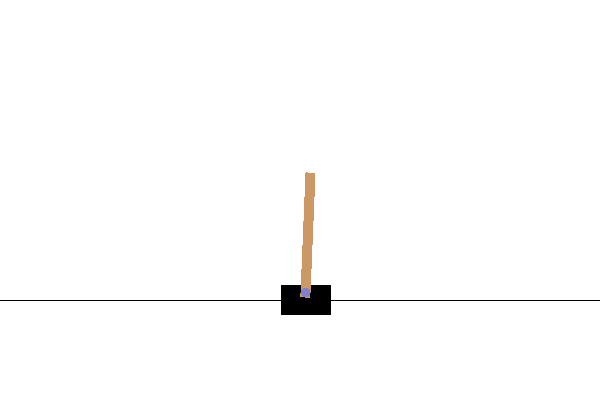

In [148]:
#@test {"skip": true}
env.reset()
PIL.Image.fromarray(env.render())

In [149]:
print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])


In [150]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [151]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


In [152]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.03571396, -0.00514856, -0.04219927,  0.02914896], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})
Next time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.03561099,  0.19055235, -0.04161628, -0.27654397], dtype=float32),
 'reward': array(1., dtype=float32),
 'step_type': array(1, dtype=int32)})


In [153]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

In [154]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [155]:
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
    return tf.keras.layers.Dense(
        num_units,
        activation=tf.keras.activations.relu,
        kernel_initializer=tf.keras.initializers.VarianceScaling(
            scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# it's output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [156]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(train_env.time_step_spec(), train_env.action_spec(), q_network=q_net, optimizer=optimizer, td_errors_loss_fn=common.element_wise_squared_loss, train_step_counter=train_step_counter)
# agent = dqn_agent.DqnAgent(
#         train_env.time_step_spec(),
#         train_env.action_spec(),
#         q_network=q_net,
#         optimizer=optimizer,
#         td_errors_loss_fn=common.element_wise_squared_loss,
#         train_step_counter=train_step_counter
#     )

agent.initialize()

In [157]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [158]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [159]:
example_environment = tf_py_environment.TFPyEnvironment(suite_gym.load('CartPole-v0'))

In [160]:
time_step = example_environment.reset()

In [161]:
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>, state=(), info=())

In [162]:
#@test {"skip": true}
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]


In [163]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

21.8

In [164]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

In [165]:
agent.collect_data_spec

Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)),
 'policy_info': (),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [166]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [167]:
#@test {"skip": true}
def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
    for _ in range(steps):
        collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, initial_collect_steps)


In [168]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)


dataset

<PrefetchDataset shapes: (Trajectory(
{action: (64, 2),
 discount: (64, 2),
 next_step_type: (64, 2),
 observation: (64, 2, 4),
 policy_info: (),
 reward: (64, 2),
 step_type: (64, 2)}), BufferInfo(ids=(64, 2), probabilities=(64,))), types: (Trajectory(
{action: tf.int64,
 discount: tf.float32,
 next_step_type: tf.int32,
 observation: tf.float32,
 policy_info: (),
 reward: tf.float32,
 step_type: tf.int32}), BufferInfo(ids=tf.int64, probabilities=tf.float32))>

In [169]:
iterator = iter(dataset)
print(iterator)

In [170]:
#@test {"skip": true}
try:
    %%time
except:
    pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

    # Collect a few steps using collect_policy and save to the replay buffer.
    collect_data(train_env, agent.collect_policy, replay_buffer, collect_steps_per_iteration)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

step = 200: loss = 69.00080871582031
step = 400: loss = 3.3463315963745117
step = 600: loss = 1.794811487197876
step = 800: loss = 1.2152172327041626
step = 1000: loss = 2.6509485244750977
step = 1000: Average Return = 39.400001525878906
step = 1200: loss = 30.326839447021484
step = 1400: loss = 5.354857444763184
step = 1600: loss = 8.126577377319336
step = 1800: loss = 9.112298965454102
step = 2000: loss = 27.86313247680664
step = 2000: Average Return = 72.19999694824219
step = 2200: loss = 20.05502700805664
step = 2400: loss = 716.552490234375
step = 2600: loss = 4233.76611328125
step = 2800: loss = 13097.53125
step = 3000: loss = 175606.375
step = 3000: Average Return = 70.4000015258789
step = 3200: loss = 568946.625
step = 3400: loss = 550468.5625
step = 3600: loss = 2530743.75
step = 3800: loss = 19837518.0
step = 4000: loss = 60173352.0
step = 4000: Average Return = 45.20000076293945
step = 4200: loss = 35044536.0
step = 4400: loss = 6761503.0
step = 4600: loss = 7833373.0
step =

(-0.4750000953674327, 250.0)

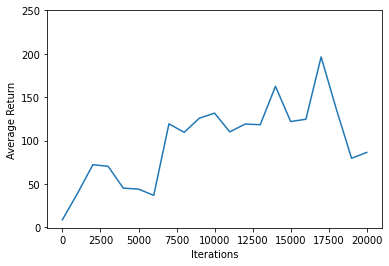

In [171]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

In [172]:
def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())

    return IPython.display.HTML(tag)

In [173]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            time_step = eval_env.reset()
            video.append_data(eval_py_env.render())
            while not time_step.is_last():
                action_step = policy.action(time_step)
                time_step = eval_env.step(action_step.action)
                video.append_data(eval_py_env.render())
    return embed_mp4(filename)

create_policy_eval_video(agent.policy, "trained-agent")

W0520 00:49:25.829411 139688517683008 ffmpeg.py:839] IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (400, 600) to (400, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to None (risking incompatibility). You may also see a FFMPEG warning concerning speedloss due to data not being aligned.


In [174]:
create_policy_eval_video(random_policy, "random-agent")

W0520 00:49:29.252990 139688517683008 ffmpeg.py:839] IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (400, 600) to (400, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to None (risking incompatibility). You may also see a FFMPEG warning concerning speedloss due to data not being aligned.
